In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift
from math import sin, cos, sqrt, atan2, radians 
from sklearn import tree, svm, linear_model, ensemble, neighbors, naive_bayes 
import dateutil
import os
from pathlib import Path
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
status_path = Path('../filtered_status.csv')
stations_path = Path('../station.csv')

In [3]:
status_df = pd.read_csv(status_path, parse_dates=['time'])
stations_df = pd.read_csv(stations_path)

In [4]:
status_df

,station_id,bikes_available,docks_available,time
0,2,2,25,2013-08-29 12:06:01
1,2,2,25,2013-08-29 12:07:01
2,2,2,25,2013-08-29 12:08:01
3,2,2,25,2013-08-29 12:09:01
4,2,2,25,2013-08-29 12:10:01
...,...,...,...,...
71977905,84,8,7,2015-08-31 23:55:02
71977906,84,8,7,2015-08-31 23:56:01
71977907,84,8,7,2015-08-31 23:57:02
71977908,84,8,7,2015-08-31 23:58:02


In [5]:
stations_df

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
...,...,...,...,...,...,...,...
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014


## Ottengo gli id delle stazioni per ogni città diversa

In [4]:
cities = stations_df['city'].unique()
cities

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [5]:
city_stations = {}

for city in cities:
    city_stations[city] = stations_df[stations_df['city'] == city]['id'].unique()

city_stations

{'San Jose': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 80, 84]),
 'Redwood City': array([21, 22, 23, 24, 25, 26, 83]),
 'Mountain View': array([27, 28, 29, 30, 31, 32, 33]),
 'Palo Alto': array([34, 35, 36, 37, 38]),
 'San Francisco': array([41, 42, 45, 46, 47, 48, 49, 50, 51, 39, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        82])}

## Prendo in cosiderazione solo gli id delle stazioni appartenenti alla città di San Francisco

In [6]:
San_Fancisco_stations = city_stations["San Francisco"]
San_Fancisco_stations

array([41, 42, 45, 46, 47, 48, 49, 50, 51, 39, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       82])

## Costruisco i dataset che mi serviranno per il training ed il test dei modelli ed il test dei pattern

Ottengo per ogni stazione una tabella che contiene per riga un timestamp e per colonne il numero di bici disponibili e il numero di docks disponibili al tempo corrente e ai 4 istanti di tempo precedenti per la stazione corrente e tutte le altre stazioni. Inoltre inserisco anche una colonna status riferita alla stazione corrente che indica lo stato (normale = N o quasi pieno = QP) all'istante di tempo successibo al timestamp di ogni riga. Dopo aver salvato questo dataset eseguo lo spit in training e test set e salvo anche quelli.

In [8]:
interval=30
window_width = 5

In [9]:

for reference_station in San_Fancisco_stations:
    merged_df = pd.DataFrame()
    for current_station in San_Fancisco_stations:
        new_df = pd.DataFrame()
        single_station_df = status_df[status_df['station_id']==current_station][['time', 'bikes_available', "docks_available"]]
        windowing_df =  single_station_df.resample(f"{interval}T", on = 'time').mean()
        #resetto l'indice
        windowing_df  = windowing_df.reset_index()
                 
        new_df['time'] = windowing_df['time']
        
        #inserisco le colonne 
        for i in reversed(range(window_width)):
            new_df[f'docks_av_{current_station}_T{i}'] =  windowing_df['docks_available'].shift(periods=i)
            new_df[f'bikes_av_{current_station}_T{i}'] =  windowing_df['bikes_available'].shift(periods=i)
        
        #se la stazione corrente è quella di riferimento, inserisco la colonna "status", shiftata indietro di 1 
        # slot temporale in modo che indichi lo stato denna stazione nello slot temporale successivo a quello di riferimento.
        # Questa colonna fungerà da label
        if (current_station == reference_station):
            windowing_df["status"] = np.where(windowing_df["docks_available"]<=2, "QP", "N")
            new_df["status"] =  windowing_df['status'].shift(periods=-1)
            
        if len(merged_df) == 0:
            merged_df = new_df.copy(deep=True)
            continue
        merged_df = pd.merge(merged_df, new_df, how='outer', on='time')
    
    #Rimuovo tutti i record con valori mancanti
    merged_df = merged_df.dropna()
    
    if (Path.cwd() / f'datasets/{interval}_{window_width}').exists() == False:
        os.makedirs(f"./datasets/{interval}_{window_width}")
        
    merged_df.to_csv(f"./datasets/{interval}_{window_width}/station{reference_station}_status.csv", index=False)

    #splitto in train e test set
    train_df, test_df = np.split(merged_df, [int(.7*len(merged_df))])
    
    #salvo la versione contente l'informazione sul tempo
    train_df.to_csv(f"./datasets/{interval}_{window_width}/Train_test_with_time/station{reference_station}_train.csv", index=False)
    test_df.to_csv(f"./datasets/{interval}_{window_width}/Train_test_with_time/station{reference_station}_test.csv", index=False)
    
    #rimuovo il tempo in quanto non è utile ai fini della classificazione
    train_df.drop(columns=["time"], inplace=True) 
    test_df.drop(columns=["time"], inplace=True) 
    
    #salvo la versione senza l'informazione sul tempo
    train_df.to_csv(f"./datasets/{interval}_{window_width}/station{reference_station}_train.csv", index=False)
    test_df.to_csv(f"./datasets/{interval}_{window_width}/station{reference_station}_test.csv", index=False)
    

In [11]:
test_df.head()

,time,docks_av_41_T4,bikes_av_41_T4,docks_av_41_T3,bikes_av_41_T3,docks_av_41_T2,bikes_av_41_T2,docks_av_41_T1,bikes_av_41_T1,docks_av_41_T0,...,bikes_av_82_T4,docks_av_82_T3,bikes_av_82_T3,docks_av_82_T2,bikes_av_82_T2,docks_av_82_T1,bikes_av_82_T1,docks_av_82_T0,bikes_av_82_T0,status
26731,2015-03-09 09:30:00,13.000000,2.000000,12.500000,2.500000,11.033333,3.966667,8.566667,6.433333,6.900000,...,7.066667,8.633333,6.366667,13.200000,1.800000,13.733333,1.266667,12.900000,2.100000,N
26732,2015-03-09 10:00:00,12.500000,2.500000,11.033333,3.966667,8.566667,6.433333,6.900000,8.100000,5.366667,...,6.366667,13.200000,1.800000,13.733333,1.266667,12.900000,2.100000,14.066667,0.933333,N
26733,2015-03-09 10:30:00,11.033333,3.966667,8.566667,6.433333,6.900000,8.100000,5.366667,9.633333,8.366667,...,1.800000,13.733333,1.266667,12.900000,2.100000,14.066667,0.933333,14.000000,1.000000,N
26734,2015-03-09 11:00:00,8.566667,6.433333,6.900000,8.100000,5.366667,9.633333,8.366667,6.633333,9.000000,...,1.266667,12.900000,2.100000,14.066667,0.933333,14.000000,1.000000,14.133333,0.866667,N
26735,2015-03-09 11:30:00,6.900000,8.100000,5.366667,9.633333,8.366667,6.633333,9.000000,6.000000,9.400000,...,2.100000,14.066667,0.933333,14.000000,1.000000,14.133333,0.866667,10.900000,4.100000,N


## Training

In [8]:
classifiers = {
    'DecisionTree': tree.DecisionTreeClassifier(random_state=42),   
    'SVC': svm.SVC(),
    'LogisticRegression': linear_model.LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    'NaiveBayes': naive_bayes.GaussianNB(),
    'RandomForest': ensemble.RandomForestClassifier(random_state=42, max_features='sqrt'),
}

Alleno i modelli con i parametri di default e li salvo in "/trained_models"

In [24]:
import time
start = time.time()

for reference_station in San_Fancisco_stations:

    train_df = pd.read_csv(f"./datasets/{interval}_{window_width}/station{reference_station}_train.csv")
    
    y = train_df['status']
    X = train_df.drop(columns=['status'])
    
    #TRAINING
    for classifier in classifiers.keys():
        model = classifiers[classifier].fit(X,y)
        
        #salvo il modello
        if (Path.cwd() / f'trained_models/{classifier}/{interval}_{window_width}').exists() == False:
            os.makedirs(f"./trained_models/{classifier}/{interval}_{window_width}")
        dump(model, f'./trained_models/{classifier}/{interval}_{window_width}/station{reference_station}_trained_model.joblib')

end = time.time()
print(f'The time of execution is: {end-start} s')

The time of execution is: 455.95252871513367 s


## Testing dei modelli allenati con i parametri di default

In [28]:
result_matrix = []

for classifier in classifiers.keys():
    
    file = open(f'test_results/default_parameters/{classifier}_{interval}_{window_width}_results.txt', "w")
    file.write(f'TESING RESULTS FOR {classifier} CLASSIFIER:\n\n')
#     tot_accuracy = 0
#     tot_recall = 0
#     tot_precision = 0
    tot_fp = 0
    tot_tp = 0
    tot_fn = 0
    tot_tn = 0
    
    for station_id in San_Fancisco_stations:
        model = load(f'./trained_models/{classifier}/{interval}_{window_width}/station{station_id}_trained_model.joblib')

        test_df = pd.read_csv(f'./datasets/{interval}_{window_width}/station{station_id}_test.csv')
        y_test = test_df['status']
        X_test = test_df.drop(columns=['status'])    

        prediction = model.predict(X_test)
        cm = confusion_matrix(y_test, prediction)

        str_= f'{classifier} FOR STATION {station_id}' + '\n'
        str_ += f'Confusion matrix:' + '\n'
        str_ += str(cm) + '\n'

        tn, fp, fn, tp = cm.ravel()
        str_+= f'tp={tp}, fn={fn}, fp={fp}, tn={tn}' +'\n'

        test_accuracy = (tn + tp) / (tn + fp + fn + tp)
        test_recall = (tp) / (tp + fn)
        test_precision = (tp) / (tp + fp)

        str_+= f'accuracy={test_accuracy}; recall={test_recall}; precision={test_precision}' +'\n\n'
        str_+= "-"*10 +'\n\n'

        tot_fp += fp
        tot_tp += tp
        tot_fn += fn
        tot_tn += tn
        
        file.write(str_)

    avg_accuracy = (tot_tn + tot_tp) / (tot_tn + tot_fp + tot_fn + tot_tp)
    avg_recall = (tot_tp) / (tot_tp + tot_fn)
    avg_precision = (tot_tp) / (tot_tp + tot_fp)
    result_matrix.append([avg_accuracy, avg_recall, avg_precision])
    avg_str = f"AVERAGE VALUES FOR {classifier}: accuracy={avg_accuracy}; recall={avg_recall}; precision={avg_precision}"
#     print(avg_str)
#     print()
#     print()
    file.write(avg_str)
    file.close()
    
results_table = pd.DataFrame(result_matrix, columns=['avg_accuracy', 'avg_recall', 'avg_precision'], index=pd.Index(classifiers.keys()))
results_table.to_csv(f"./test_results/default_parameters/Overall_results_{interval}_{window_width}.csv")
results_table.head()

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipyker

,avg_accuracy,avg_recall,avg_precision
DecisionTree,0.968716,0.535608,0.559921
SVC,0.969961,0.202770,0.793037
LogisticRegression,0.974696,0.564590,0.667915
NaiveBayes,0.867180,0.750643,0.176197
RandomForest,0.976811,0.406726,0.865866


[Text(2204.7804878048782, 2117.178947368421, 'bikes_av_82_T0 <= 12.817\ngini = 0.03\nsamples = 19072\nvalue = [18784, 288]\nclass = N'),
 Text(857.4146341463415, 2002.7368421052633, 'docks_av_82_T0 <= 2.95\ngini = 0.008\nsamples = 18757\nvalue = [18684, 73]\nclass = N'),
 Text(217.75609756097563, 1888.2947368421053, 'bikes_av_50_T4 <= 9.383000000000001\ngini = 0.389\nsamples = 102\nvalue = [75, 27]\nclass = N'),
 Text(130.65365853658537, 1773.8526315789475, 'docks_av_64_T1 <= 1.567\ngini = 0.078\nsamples = 49\nvalue = [47, 2]\nclass = N'),
 Text(87.10243902439025, 1659.4105263157894, 'docks_av_54_T0 <= 12.883000000000001\ngini = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = QP'),
 Text(43.551219512195125, 1544.9684210526316, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = QP'),
 Text(130.65365853658537, 1544.9684210526316, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = N'),
 Text(174.2048780487805, 1659.4105263157894, 'gini = 0.0\nsamples = 46\nvalue = [46, 0]\nclass = N'),
 Text(30

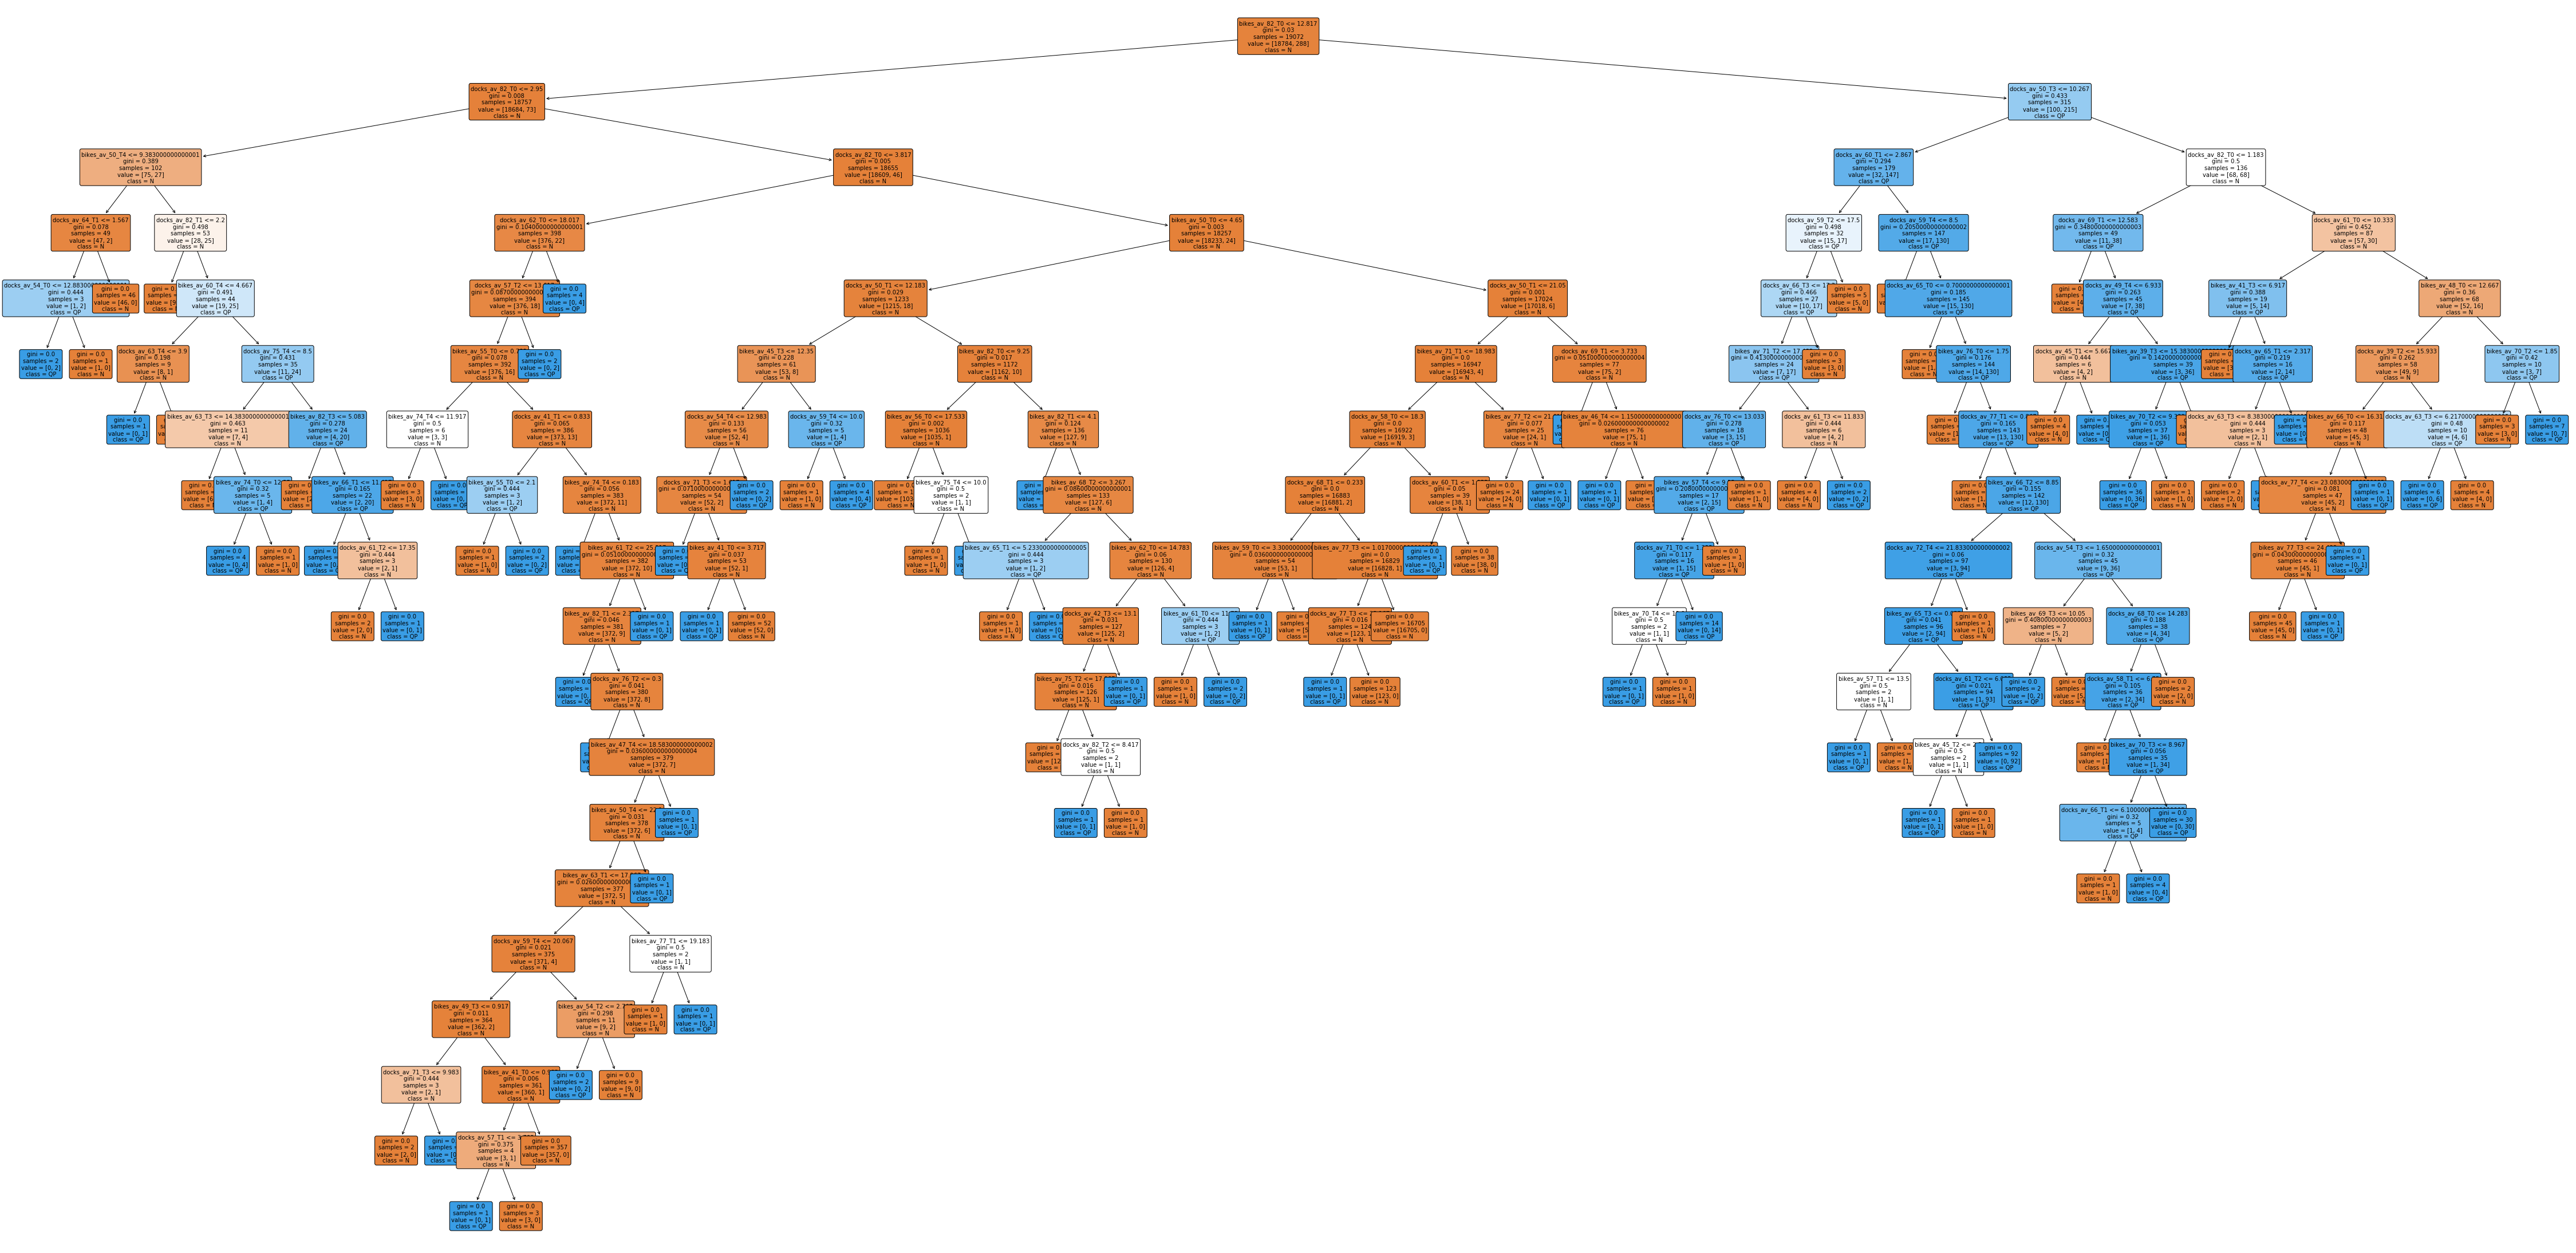

In [46]:
# plt.figure(figsize=(80,40))
# tree.plot_tree(model, fontsize=10, feature_names=X.columns, class_names=['N', 'QP'], label='all', filled=True, rounded=True)